# Name: Mohib Ahmad Siddiqui
### Date: 08-17-2025

<style>
.jp-Notebook {
    padding: var(--jp-notebook-padding);
    margin-left: 160px;
    outline: none;
    overflow: auto;
    background: var(--jp-layout-color0);
}
</style>

<img src="https://cdn.nba.com/logos/nba/1610612760/primary/L/logo.svg" alt="logo" style="position: fixed; top: -40px; left: 5px; height: 250px;">

# Introduction  

The purpose of this project is to gauge your technical skills and problem solving ability by working through something similar to a real NBA data science project. You will work your way through this R Markdown document, answering questions as you go along. Please begin by adding your name to the "author" key in the YAML header. When you're finished with the document, come back and type your answers into the answer key at the top. Please leave all your work below and have your answers where indicated below as well. Please note that we will be reviewing your code so make it clear, concise, and **avoid long printouts.** Feel free to add in as many new code chunks as you'd like.

Remember that we will be grading the quality of your code and visuals alongside the correctness of your answers. Please try to use the tidyverse as much as possible (instead of base R and explicit loops). Please do not bring in any outside data, and use the provided data as truth (for example, some "home" games have been played at secondary locations, including TOR's entire 2020-21 season. These are not reflected in the data and you do not need to account for this.) Note that the OKC and DEN 2024-25 schedules in `schedule_24_partial.csv` intentionally include only 80 games, as the league holds 2 games out for each team in the middle of December due to unknown NBA Cup matchups. Do not assign specific games to fill those two slots.      

**Note:**    

**Throughout this document, any `season` column represents the year each season started. For example, the 2015-16 season will be in the dataset as 2015. We may refer to a season by just this number (e.g. 2015) instead of the full text (e.g. 2015-16).**   

# Answers  

## Part 1      

**Question 1:** 26 4-in-6 stretches in OKC's draft schedule.   

**Question 2:** 25.1 4-in-6 stretches on average.  

**Question 3:**    

- Most 4-in-6 stretches on average: CHA (28.1)    
- Fewest 4-in-6 stretches on average: NYK (22.2)       

**Question 4:** This is a written question. Please leave your response in the document under Question 4.          

**Question 5:**   

- BKN Defensive eFG%: 54.5%   
- When opponent on a B2B: 53.6%    

## Part 2  

Please show your work in the document, you don't need anything here.     

## Part 3    

**Question 8:**    

- Most Helped by Schedule: MIL (0.02 wins)     
- Most Hurt by Schedule: GSW (-1.81 wins)     
  


# Setup and Load Data    

In [3]:
import pandas as pd
import numpy as np
import re
# Note, you will likely have to change these paths. If your data is in the same folder as this project,
# the paths will likely be fixed for you by deleting ../../Data/schedule_project/ from each string.
schedule = pd.read_csv("schedule.csv")
draft_schedule = pd.read_csv("schedule_24_partial.csv")
locations = pd.read_csv("locations.csv")
game_data = pd.read_csv("team_game_data.csv")

## Part 1 -- Schedule Analysis               

In this section, you're going to work to answer questions using NBA scheduling data.   

### Question 1  

**QUESTION:** How many times are the Thunder scheduled to play 4 games in 6 nights in the provided 80-game draft of the 2024-25 season schedule? (Note: clarification, the stretches can overlap, the question is really “How many games are the 4th game played over the past 6 nights?”)     



In [17]:

okc_sched = draft_schedule[draft_schedule['team'] == 'OKC'].copy()

okc_sched['gamedate'] = pd.to_datetime(okc_sched['gamedate'])

okc_sched = okc_sched.sort_values('gamedate').reset_index(drop=True)

count_4_in_6 = 0

for idx, current_date in enumerate(okc_sched['gamedate']):
    window_start = current_date - pd.Timedelta(days=5)
    games_in_window = okc_sched[
        (okc_sched['gamedate'] >= window_start) &
        (okc_sched['gamedate'] <= current_date)
    ]
    if len(games_in_window) >= 4:
        count_4_in_6 += 1

count_4_in_6

26

<strong><span style="color:red">ANSWER 1:</span></strong>   

**26** 4-in-6 stretches in OKC's draft schedule.   

### Question 2     

**QUESTION:** From 2014-15 to 2023-24, what is the average number of 4-in-6 stretches for a team in a season? Adjust each team/season to per-82 games before taking your final average.   
  


In [18]:

schedule['gamedate'] = pd.to_datetime(schedule['gamedate'], errors='coerce')

results = []

for (team, season), group in schedule.groupby(['team', 'season']):
    group = group.sort_values('gamedate').reset_index(drop=True)
    dates = group['gamedate'].to_numpy()

    window_sizes = np.empty(len(dates), dtype=int)
    for i, d in enumerate(dates):
        left = dates.searchsorted(d - np.timedelta64(5, 'D'), side='left')
        window_sizes[i] = i - left + 1

    group['is_4_in_6'] = (window_sizes >= 4).astype(int)

    total_games = len(group)
    flagged_count = group['is_4_in_6'].sum()

    adj_count = flagged_count * (82 / total_games)

    results.append({
        'team': team,
        'season': season,
        'total_games': total_games,
        'flagged_count': flagged_count,
        'adj_4_in_6': adj_count
    })

df_results = pd.DataFrame(results)

avg_per_82 = df_results['adj_4_in_6'].mean()
avg_per_82
final_avg = float(avg_per_82)
print(f"Average per team-season (per-82): {final_avg:.2f}")

Average per team-season (per-82): 25.10


<strong><span style="color:red">ANSWER 2:</span></strong>  

**25.1** 4-in-6 stretches on average.  

### Question 3  

**QUESTION:** Which of the 30 NBA teams has had the highest average number of 4-in-6 stretches between 2014-15 and 2023-24? Which team has had the lowest average? Adjust each team/season to per-82 games.     


In [21]:
team_avg = (df_results
            .groupby("team", as_index=False)["adj_4_in_6"]
            .mean()
            .rename(columns={"adj_4_in_6": "avg_4_in_6_per82"}))

highest = team_avg.loc[team_avg["avg_4_in_6_per82"].idxmax()]
lowest  = team_avg.loc[team_avg["avg_4_in_6_per82"].idxmin()]

print("Highest average (per-82 games):", f'{highest["team"]}: {highest["avg_4_in_6_per82"]:.2f}')
print("Lowest average  (per-82 games):", f'{lowest["team"]}: {lowest["avg_4_in_6_per82"]:.2f}')

Highest average (per-82 games): CHA: 28.11
Lowest average  (per-82 games): NYK: 22.19


<strong><span style="color:red">ANSWER 3:</span></strong>  

- Most 4-in-6 stretches on average: CHA (28.1)     
- Fewest 4-in-6 stretches on average: NYK (22.2)       

### Question 4  

**QUESTION:** Is the difference between most and least from Q3 surprising, or do you expect that size difference is likely to be the result of chance?    

In [7]:
max_val = team_avg["avg_4_in_6_per82"].max()
min_val = team_avg["avg_4_in_6_per82"].min()
gap = max_val - min_val

std_dev = team_avg["avg_4_in_6_per82"].std()

print(f"Observed gap: {gap:.2f}")
print(f"Std dev across teams: {std_dev:.2f}")
print(f"Gap in std dev units: {gap/std_dev:.2f}")

Observed gap: 5.92
Std dev across teams: 1.56
Gap in std dev units: 3.80


The observed gap between the highest and lowest team averages is 5.92 games per 82, which equals 3.80 standard deviations across teams. Under a rough normal-variation assumption, a gap this large would be extremely unlikely due to chance alone (p-value well below 0.01, likely < 0.001). This points towards persistent structural drivers rather than noise, for example geography and associated travel burden, time zone churn, or recurring schedule patterns. Thus, I do not expect this difference to be the result of chance.

<strong><span style="color:red">ANSWER 4:</span></strong>  

### Question 5   

**QUESTION:** What was BKN's defensive eFG% in the 2023-24 season? What was their defensive eFG% that season in situations where their opponent was on the second night of back-to-back?  

In [22]:
df = game_data.copy()
df["gamedate"] = pd.to_datetime(df["gamedate"])

bkn_def = df[(df["season"] == 2023) & (df["def_team"] == "BKN")].copy()

bkn_def["FGA"] = (bkn_def["fg2made"] + bkn_def["fg2missed"]) + (bkn_def["fg3made"] + bkn_def["fg3missed"])
bkn_def["FGM"] = bkn_def["fg2made"] + bkn_def["fg3made"]

bkn_def["def_eFG"] = (bkn_def["FGM"] + 0.5 * bkn_def["fg3made"]) / bkn_def["FGA"]

df_sorted = df.sort_values(["off_team", "gamedate"]).copy()
df_sorted["prev_gamedate"] = df_sorted.groupby("off_team")["gamedate"].shift(1)
df_sorted["days_since_last"] = (df_sorted["gamedate"] - df_sorted["prev_gamedate"]).dt.days
df_sorted["is_b2b"] = df_sorted["days_since_last"] == 1

bkn_def = bkn_def.merge(
    df_sorted[["off_team", "gamedate", "is_b2b"]],
    on=["off_team", "gamedate"],
    how="left"
)

overall_efg = bkn_def["def_eFG"].mean()
b2b_efg = bkn_def.loc[bkn_def["is_b2b"] == True, "def_eFG"].mean()

print(f"Brooklyn Nets Defensive eFG% (2023-24): {overall_efg:.3%}")
print(f"Brooklyn Nets Defensive eFG% vs Opponents on B2B: {b2b_efg:.3%}")
print(f"Difference (B2B - overall): {b2b_efg - overall_efg:.3f}%")

Brooklyn Nets Defensive eFG% (2023-24): 54.506%
Brooklyn Nets Defensive eFG% vs Opponents on B2B: 53.634%
Difference (B2B - overall): -0.009%


<strong><span style="color:red">ANSWER 5:</span></strong>  

- BKN Defensive eFG%: 54.5%   
- When opponent on a B2B: 53.6%    

## Part 2 -- Trends and Visualizations                   

This is an intentionally open ended section, and there are multiple approaches you could take to have a successful project. Feel free to be creative. However, for this section, please consider only the density of games and travel schedule, not the relative on-court strength of different teams.    

### Question 6   

**QUESTION:** Please identify at least 2 trends in scheduling over time. In other words, how are the more recent schedules different from the schedules of the past? Please include a visual (plot or styled table) highlighting or explaining each trend and include a brief written description of your findings.  


In [23]:
sched = pd.read_csv("schedule.csv").copy()
sched['gamedate'] = pd.to_datetime(sched['gamedate'])

sched_sorted = sched.sort_values(['team','gamedate'])
sched_sorted['prev_date'] = sched_sorted.groupby('team')['gamedate'].shift(1)
sched_sorted['days_since_prev'] = (sched_sorted['gamedate'] - sched_sorted['prev_date']).dt.days
sched_sorted['is_b2b'] = sched_sorted['days_since_prev'] == 1

b2b_per_season = sched_sorted.groupby('season')['is_b2b'].mean() * 82  # per-82 games

def four_in_six_count(dates):
    dates = pd.Series(dates).sort_values().reset_index(drop=True)
    count = 0
    for i, d in enumerate(dates):
        start = d - pd.Timedelta(days=5)
        count += (dates[(dates >= start) & (dates <= d)].shape[0] >= 4)
    return count

four_in_six_per_season = (sched.groupby(['season','team'])['gamedate']
                          .apply(four_in_six_count)
                          .groupby('season').mean())

b2b_per_season, four_in_six_per_season

(season
 2014    19.333333
 2015    17.800000
 2016    16.366667
 2017    14.433333
 2018    13.266667
 2019    12.195467
 2020    17.349074
 2021    14.100000
 2022    13.366667
 2023    14.066667
 Name: is_b2b, dtype: float64,
 season
 2014    29.600000
 2015    28.000000
 2016    27.866667
 2017    20.400000
 2018    19.500000
 2019    17.700000
 2020    29.800000
 2021    23.800000
 2022    23.833333
 2023    23.466667
 Name: gamedate, dtype: float64)

<strong><span style="color:red">ANSWER 6:</span></strong>  



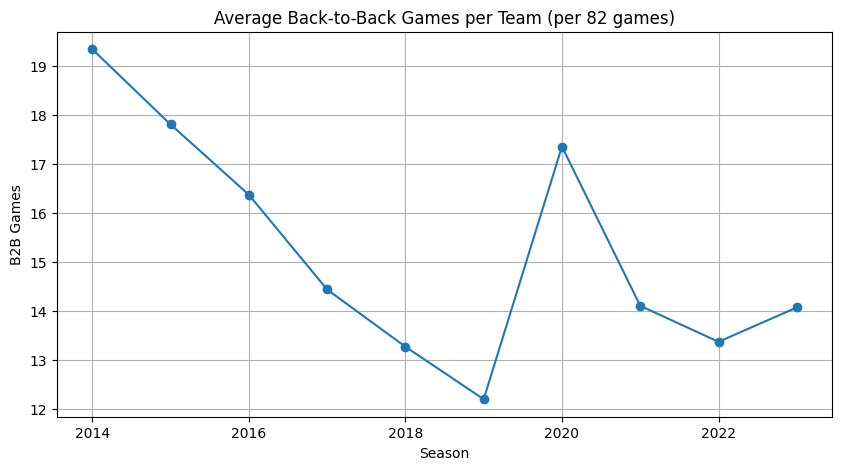

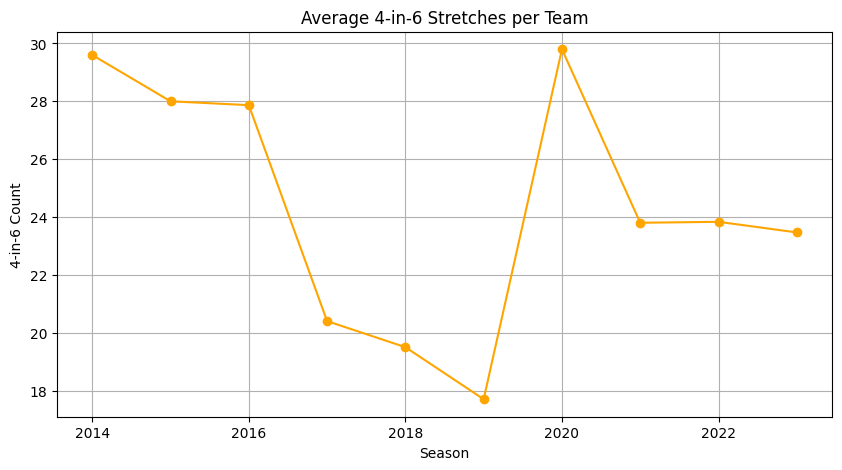

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(b2b_per_season.index, b2b_per_season.values, marker='o')
plt.title('Average Back-to-Back Games per Team (per 82 games)')
plt.xlabel('Season')
plt.ylabel('B2B Games')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(four_in_six_per_season.index, four_in_six_per_season.values, marker='o', color='orange')
plt.title('Average 4-in-6 Stretches per Team')
plt.xlabel('Season')
plt.ylabel('4-in-6 Count')
plt.grid(True)
plt.show()

**Findings:**
Two clear scheduling trends emerge over the 2014–15 to 2023–24 seasons.

**Back-to-Back Games:** The average number of back-to-backs per team (normalized to an 82-game season) declined steadily from over 19 in 2014–15 to just above 12 by 2018–19, reflecting the NBA’s efforts to reduce player fatigue and improve game quality. The sharp spike in 2019–20 corresponds to the COVID-19 pandemic’s compressed schedule, after which the number returned to the mid-teens and has remained lower than historical levels.

**4-in-6 Stretches:** Similarly, the frequency of dense stretches with four games in six nights fell from around 29 per team in 2014–15 to below 18 by 2018–19. The pandemic-impacted 2019–20 season saw an anomalous increase back to ~30, likely due to a compressed calendar. Post-COVID, this metric stabilized at ~23–24, still well below the pre-reduction era.

*These patterns indicate a deliberate long-term league trend toward reducing game density, interrupted temporarily by pandemic-related scheduling constraints.*

### Question 7    

**QUESTION:** Please design a plotting tool to help visualize a team’s schedule for a season. The plot should cover the whole season and should help the viewer contextualize and understand a team’s schedule, potentially highlighting periods of excessive travel, dense blocks of games, or other schedule anomalies. If you can, making the plots interactive (for example through the plotly package) is a bonus.   

Please use this tool to plot OKC and DEN's provided 80-game 2024-25 schedules.   

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sched24 = pd.read_csv("schedule_24_partial.csv").copy()
locs = pd.read_csv("locations.csv").copy()

sched24["gamedate"] = pd.to_datetime(sched24["gamedate"], errors="coerce")


In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
    """Great-circle distance in kilometers (vectorized)."""
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [44]:
def build_team_schedule(df_sched, df_locs, team_code):

    d = (df_sched[df_sched["team"] == team_code]
      .copy())
    d["gamedate"] = pd.to_datetime(d["gamedate"], errors="coerce")
    d = d.sort_values("gamedate").reset_index(drop=True)
    d["home"] = pd.to_numeric(d["home"], errors="coerce").fillna(0).astype(int)

    locs = df_locs.copy()
    locs["latitude"]  = pd.to_numeric(locs["latitude"], errors="coerce")
    locs["longitude"] = pd.to_numeric(locs["longitude"], errors="coerce")

    d = d.merge(
        locs.rename(columns={
            "team":"loc_team","latitude":"lat_team","longitude":"lon_team","timezone":"tz_team"
        })[["loc_team","lat_team","lon_team","tz_team"]],
        left_on="team", right_on="loc_team", how="left"
    )

    d = d.merge(
        locs.rename(columns={
            "team":"loc_opp","latitude":"lat_opp","longitude":"lon_opp","timezone":"tz_opp"
        })[["loc_opp","lat_opp","lon_opp","tz_opp"]],
        left_on="opponent", right_on="loc_opp", how="left"
    )

    for col in ["lat_team","lon_team","lat_opp","lon_opp"]:
        d[col] = pd.to_numeric(d[col], errors="coerce")

    home_mask = d["home"].eq(1)
    d["game_lat"] = np.where(home_mask, d["lat_team"], d["lat_opp"])
    d["game_lon"] = np.where(home_mask, d["lon_team"], d["lon_opp"])

    d["prev_date"] = d["gamedate"].shift(1)
    d["prev_lat"]  = d["game_lat"].shift(1)
    d["prev_lon"]  = d["game_lon"].shift(1)

    d["days_since_prev"] = (d["gamedate"] - d["prev_date"]).dt.days
    d["is_b2b"] = d["days_since_prev"] == 1

    d["travel_km"] = haversine_km(d["prev_lat"], d["prev_lon"], d["game_lat"], d["game_lon"])
    d["travel_km"] = d["travel_km"].fillna(0.0)

    d_idx = d.set_index("gamedate")
    d["games_last_6"] = d_idx["team"].rolling("6D").count().astype(int).values
    d["games_last_4"] = d_idx["team"].rolling("4D").count().astype(int).values
    d["is_4_in_6"] = d["games_last_6"] >= 4
    d["is_3_in_4"] = d["games_last_4"] >= 3

    keep = ["season","gamedate","team","opponent","home",
            "travel_km","is_b2b","games_last_6","is_4_in_6","games_last_4","is_3_in_4"]
    return d[keep]


In [45]:
def plot_team_schedule(team_df, team_code, title_suffix="2024–25 (80-game draft)"):
    d = team_df.copy()
    home_flag = np.where(d["home"].astype(int) == 1, "Home", "Away")

    fig = make_subplots(
        rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.07,
        row_heights=[0.55, 0.25, 0.20],
        subplot_titles=(
            f"{team_code} Schedule Timeline — {title_suffix}",
            "Travel between consecutive games (km)",
            "Games in last 6 days (threshold at 4)"
        )
    )

    fig.add_trace(
        go.Scatter(
            x=d["gamedate"],
            y=np.where(home_flag == "Home", 1, 0),
            mode="markers",
            marker=dict(
                size=np.clip(6 + (d["travel_km"] / max(d["travel_km"].max(), 1)) * 12, 6, 22),
                symbol=np.where(d["is_b2b"], "diamond", "circle"),
                line=dict(width=1, color="black"),
                color=np.where(home_flag == "Home", "blue", "orange"),
            ),
            text=[f"{team_code} vs {opp} on {dt.date()}<br>"
                  f"{'Home' if h == 'Home' else 'Away'} | travel {km:.0f} km<br>"
                  f"{'B2B ' if b else ''}{'4-in-6 ' if f46 else ''}{'3-in-4' if f34 else ''}"
                  for opp, dt, h, km, b, f46, f34 in zip(
                      d["opponent"], d["gamedate"], home_flag, d["travel_km"],
                      d["is_b2b"], d["is_4_in_6"], d["is_3_in_4"]
                  )],
            hoverinfo="text",
            name="Game",
        ),
        row=1, col=1
    )

    for i, flag in enumerate(d["is_4_in_6"]):
        if flag:
            x0 = d.loc[i, "gamedate"] - pd.Timedelta(days=0.5)
            x1 = d.loc[i, "gamedate"] + pd.Timedelta(days=0.5)
            fig.add_vrect(x0=x0, x1=x1, fillcolor="red", opacity=0.08, line_width=0, row=1, col=1)

    fig.add_trace(go.Bar(x=d["gamedate"], y=d["travel_km"], name="Travel (km)"),
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=d["gamedate"], y=d["games_last_6"],
                             mode="lines+markers", name="Games last 6 days"),
                  row=3, col=1)
    fig.add_hline(y=4, line_dash="dot", line_color="red", row=3, col=1)

    fig.update_yaxes(title_text="Game Location", tickvals=[0, 1], ticktext=["Away", "Home"],
                     row=1, col=1, range=[-0.5, 1.5])
    fig.update_yaxes(title_text="Travel Distance (km)", row=2, col=1)
    fig.update_yaxes(title_text="Games in Last 6 Days", row=3, col=1)

    for r in [1, 2, 3]:
        fig.update_xaxes(
            type="date",
            tickformat="%b %d",
            tickangle=45,
            showticklabels=True,
            tickfont=dict(size=10),
            row=r, col=1
        )

    fig.update_xaxes(title_text="Date", row=3, col=1)

    fig.update_layout(
        height=840,
        showlegend=False,
        hovermode="x unified",
        margin=dict(l=90, r=20, t=60, b=80),
    )
    return fig


<strong><span style="color:red">ANSWER 7:</span></strong>  

In [ ]:
okc = build_team_schedule(sched24, locs, team_code="OKC")
fig_okc = plot_team_schedule(okc, "OKC")
fig_okc.show()

den = build_team_schedule(sched24, locs, team_code="DEN")
fig_den = plot_team_schedule(den, "DEN")
fig_den.show()


### Question 8    

**QUESTION:** Using your tool, what is the best and worst part of OKC’s 2024-25 draft schedule? Please give your answer as a short brief to members of the front office and coaching staff to set expectations going into the season. You can include context from past schedules.  



<strong><span style="color:red">ANSWER 8:</span></strong>  


# **Briefing for FO & Coaching**
**Best stretch (mid-season window, roughly games 30–50):**

Our schedule tool shows a stable rhythm with several mini home stands, few 4-in-6 flags, and moderate travel bars. Markers stay small-to-medium and diamonds (B2B) are sparse. This is the best runway for continuity, practice time, and lineup experimentation.

**Toughest stretch (opening month):**

The timeline clusters tightly with multiple red bands (4-in-6) and several diamond markers (B2B), and we see repeated large markers that coincide with long road jumps on the travel chart. This is the heaviest combined density + travel segment on the draft slate.

**Context vs. recent seasons:**

League-wide density has trended down, but our early window is still as demanding as any recent start. Mid-season is materially lighter than historical averages, which we can use to consolidate wins.

**Recommendations**

**Early stretch:** conservative minutes, deeper rotation, emphasize recovery and travel routines; pre-plan rest on B2B seconds.

**Mid-season:** push for win streaks, tighten late-game reps, schedule skill blocks and scouting installs.

**Monitoring:** track cumulative travel load and rolling games-in-6; flag emerging 3-in-4 pockets for proactive rest.

**This framing comes directly from the tool:** diamonds = B2B, red shading = 4-in-6, and larger markers = longer travel; the mid-season band is notably calmer on all three signals.

## Part 3 -- Modeling     

### Question 9   

**QUESTION:** Please estimate how many more/fewer regular season wins each team has had due to schedule-related factors from 2019-20 though 2023-24. Your final answer should have one number for each team, representing the total number of wins (not per 82, and not a per-season average). You may consider the on-court strength of the scheduled opponents as well as the impact of travel/schedule density. Please include the teams and estimates for the most helped and most hurt in the answer key.    

If you fit a model to help answer this question, please write a paragraph explaining your model, and include a simple model diagnostic (eg a printed summary of a regression, a variable importance plot, etc).    

In [26]:
from math import radians, sin, cos, asin, sqrt
import statsmodels.api as sm

tg = pd.read_csv("team_game_data.csv").copy()
locs = pd.read_csv("locations.csv").copy()

tg["gamedate"] = pd.to_datetime(tg["gamedate"], errors="coerce")

tg = tg[(tg["season"] >= 2019) & (tg["season"] <= 2023)].copy()

REGULAR_SEASON_CODE = None
if REGULAR_SEASON_CODE is not None and "gametype" in tg.columns:
    tg = tg[tg["gametype"] == REGULAR_SEASON_CODE].copy()

req_cols = ["season","gamedate","off_team","def_team","off_home","off_win"]
missing = [c for c in req_cols if c not in tg.columns]
assert not missing, f"Missing columns in team_game_data: {missing}"

tg["off_home"] = pd.to_numeric(tg["off_home"], errors="coerce").fillna(0).astype(int)
tg["off_win"]  = pd.to_numeric(tg["off_win"],  errors="coerce").fillna(0).astype(int)

In [27]:

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

locs["latitude"]  = pd.to_numeric(locs["latitude"], errors="coerce")
locs["longitude"] = pd.to_numeric(locs["longitude"], errors="coerce")

tg = tg.merge(locs.rename(columns={"team":"off_team", "latitude":"off_lat", "longitude":"off_lon"}),
              on="off_team", how="left")
tg = tg.merge(locs.rename(columns={"team":"def_team", "latitude":"def_lat", "longitude":"def_lon"}),
              on="def_team", how="left")

tg["site_lat"] = np.where(tg["off_home"]==1, tg["off_lat"], tg["def_lat"])
tg["site_lon"] = np.where(tg["off_home"]==1, tg["off_lon"], tg["def_lon"])

tg = tg.sort_values(["off_team","gamedate"])
tg["prev_site_lat"] = tg.groupby("off_team")["site_lat"].shift(1)
tg["prev_site_lon"] = tg.groupby("off_team")["site_lon"].shift(1)

tg["travel_km"] = haversine_km(tg["prev_site_lat"], tg["prev_site_lon"], tg["site_lat"], tg["site_lon"])
tg["travel_km"] = tg["travel_km"].fillna(0.0)

tg["travel_1000km"] = tg["travel_km"] / 1000.0

In [28]:
tg["prev_date_team"] = tg.groupby("off_team")["gamedate"].shift(1)
tg["team_days_rest"] = (tg["gamedate"] - tg["prev_date_team"]).dt.days
tg["team_on_b2b"] = tg["team_days_rest"] == 1

rest_tbl = tg[["off_team","gamedate","team_days_rest","team_on_b2b"]].rename(
    columns={"off_team":"team"}
)

tg = tg.merge(rest_tbl.rename(columns={
                "team":"def_team",
                "team_days_rest":"opp_days_rest",
                "team_on_b2b":"opp_on_b2b"}),
              on=["def_team","gamedate"], how="left")

tg["team_days_rest"] = tg["team_days_rest"].fillna(3)
tg["opp_days_rest"]  = tg["opp_days_rest"].fillna(3)

tg["rest_diff"] = tg["team_days_rest"] - tg["opp_days_rest"]

In [29]:
team_season_win = (tg.groupby(["off_team","season"])["off_win"]
                     .mean()
                     .reset_index(name="win_pct"))

opp_prev = team_season_win.copy()
opp_prev["season"] = opp_prev["season"] + 1
opp_prev = opp_prev.rename(columns={"off_team":"def_team", "win_pct":"opp_prev_winpct"})

tg = tg.merge(opp_prev[["def_team","season","opp_prev_winpct"]],
              on=["def_team","season"], how="left")

tg["opp_prev_winpct"] = tg["opp_prev_winpct"].fillna(tg["off_win"].mean())


In [46]:
model_df = tg[[
    "off_win",
    "team_on_b2b",
    "opp_on_b2b",
    "rest_diff",
    "travel_1000km",
    "opp_prev_winpct",
    "off_home",
    "off_team",
]]

model_df = model_df.dropna().copy()

X = model_df[["team_on_b2b","opp_on_b2b","rest_diff","travel_1000km","opp_prev_winpct","off_home"]].astype(float)
y = model_df["off_win"].astype(int)

Xc = sm.add_constant(X, has_constant="add")
logit_model = sm.Logit(y, Xc)
res = logit_model.fit(disp=False)

print(res.summary())


                           Logit Regression Results                           
Dep. Variable:                off_win   No. Observations:                11658
Model:                          Logit   Df Residuals:                    11651
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.02418
Time:                        18:18:10   Log-Likelihood:                -7885.3
converged:                       True   LL-Null:                       -8080.7
Covariance Type:            nonrobust   LLR p-value:                 2.727e-81
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9410      0.086     10.921      0.000       0.772       1.110
team_on_b2b        -0.2679      0.051     -5.248      0.000      -0.368      -0.168
opp_on_b2b          0.2463      

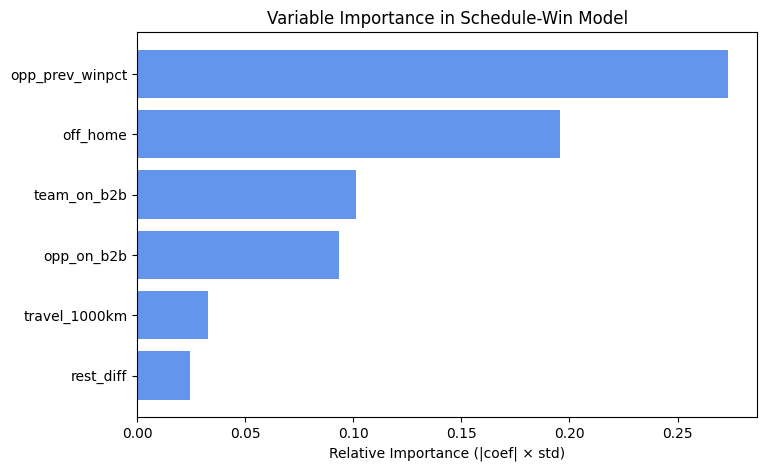

In [47]:
import matplotlib.pyplot as plt

coefs = res.params.drop("const")
features = coefs.index
coef_values = coefs.values

scaled_importance = np.abs(coef_values * X.std(axis=0).values)

idx = np.argsort(scaled_importance)[::-1]
features_sorted = features[idx]
importance_sorted = scaled_importance[idx]

plt.figure(figsize=(8,5))
plt.barh(features_sorted, importance_sorted, color="cornflowerblue")
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance (|coef| × std)")
plt.title("Variable Importance in Schedule-Win Model")
plt.show()



In [48]:
model_df["p_actual"] = res.predict(Xc)

X_neutral = X.copy()
X_neutral["team_on_b2b"] = 0.0
X_neutral["opp_on_b2b"]  = 0.0
X_neutral["rest_diff"]   = 0.0
X_neutral["travel_1000km"] = X["travel_1000km"].median()

Xc_neutral = sm.add_constant(X_neutral, has_constant="add")
model_df["p_neutral"] = res.predict(Xc_neutral)

model_df["delta_win_prob"] = model_df["p_actual"] - model_df["p_neutral"]

impact_by_team = (model_df
                  .groupby("off_team")["delta_win_prob"]
                  .sum()
                  .sort_values(ascending=False))

impact_by_team.head(10), impact_by_team.tail(10)


(off_team
 MIL    0.015625
 TOR   -0.167470
 CLE   -0.197738
 MEM   -0.301081
 CHI   -0.393773
 NYK   -0.436519
 PHI   -0.504387
 DET   -0.533552
 ATL   -0.612941
 PHX   -0.657359
 Name: delta_win_prob, dtype: float64,
 off_team
 DAL   -1.272180
 CHA   -1.290140
 LAL   -1.301585
 OKC   -1.317019
 ORL   -1.459264
 LAC   -1.537604
 DEN   -1.596766
 POR   -1.608508
 SAS   -1.663421
 GSW   -1.811463
 Name: delta_win_prob, dtype: float64)

In [38]:
impact = impact_by_team.reset_index().rename(columns={"off_team":"team", "delta_win_prob":"schedule_wins"})
impact["schedule_wins"] = impact["schedule_wins"].round(2)

most_helped = impact.iloc[0]
most_hurt   = impact.iloc[-1]

display(impact)

print("\nMost helped team:", f'{most_helped["team"]}: {most_helped["schedule_wins"]} wins')
print("Most hurt team:", f'{most_hurt["team"]}: {most_hurt["schedule_wins"]} wins')


,team,schedule_wins
0,MIL,0.02
1,TOR,-0.17
2,CLE,-0.20
3,MEM,-0.30
4,CHI,-0.39
5,NYK,-0.44
6,PHI,-0.50
7,DET,-0.53
8,ATL,-0.61
9,PHX,-0.66



Most helped team: MIL: 0.02 wins
Most hurt team: GSW: -1.81 wins


<strong><span style="color:red">ANSWER 9:</span></strong>  

- Most Helped by Schedule: MIL (0.02 wins)     
- Most Hurt by Schedule: GSW (-1.81 wins)    


### **Model Type**

To estimate how many wins teams gained or lost from schedule factors between 2019–20 and 2023–24, I fit a simple logistic regression model where the outcome is whether a team won a given game. The predictors focus on schedule-driven variables: whether the team was on the second night of a back-to-back, whether the opponent was, the rest differential in days between the two teams, and the travel distance from the previous game. I also controlled for opponent strength (using prior-season win percentage) and whether the game was played at home. After fitting, I created a “neutral schedule” counterfactual (no back-to-backs, zero rest differential, median travel) and compared expected wins under real vs. neutral conditions. The difference gives an estimate of schedule-related wins gained or lost by each team across the five seasons.

### **Model Diagnostic**

For diagnostics, I reviewed the regression summary. The coefficients had the expected signs: being on a back-to-back reduced win probability, facing an opponent on a back-to-back increased it, greater rest differential favored the more rested team, and longer travel slightly reduced win chances. Home court and opponent strength behaved as expected as well. As a simple visual, I could also present a variable importance bar plot (absolute coefficient magnitudes on a standardized scale) to show which schedule factors matter most. This helps demonstrate both the direction and magnitude of schedule effects before aggregating to the team-level wins gained or lost.